In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels as sm
import statsmodels.tsa.api as tsa
import antropy
import ruptures as rpt

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from joblib import Parallel, delayed
from tqdm.auto import tqdm
import logging
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

d:\anaconda3\envs\adia\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. read dataset
print("Loading data...")
X_train = pd.read_parquet('./data/X_train.parquet')
y_train = pd.read_parquet('./data/y_train.parquet')
print("Data loaded.")

Loading data...
Data loaded.


In [3]:
# 2. feature engineering
FEATURE_FUNCTIONS = []

# def feature(func):
#     """一个用于注册特征函数的装饰器"""
#     FEATURE_FUNCTIONS.append(func)
#     return func

# --- 1. 分布统计特征 ---
# @feature
def distributional_stats(u: pd.DataFrame) -> dict:
    """特征提取：比较两个周期的分布（均值、标准差、偏度、峰度）以及KS检验、t检验。"""
    s1 = u['value'][u['period'] == 0]
    s2 = u['value'][u['period'] == 1]
    feats = {}
    
    mean1, mean2 = s1.mean(), s2.mean()
    feats['mean_diff'] = mean2 - mean1
    
    std1, std2 = s1.std(), s2.std()
    feats['std_diff'] = std2 - std1
    if std1 > 1e-6:
        feats['std_ratio'] = std2 / std1
    else:
        feats['std_ratio'] = 1.0 if std2 < 1e-6 else 1e6
    
    feats['skew_diff'] = s2.skew() - s1.skew()
    feats['kurt_diff'] = s2.kurt() - s1.kurt()
    
    if len(s1) > 1 and len(s2) > 1:
        ks_stat, ks_pvalue = scipy.stats.ks_2samp(s1, s2)
        feats['ks_stat'] = ks_stat
        feats['ks_pvalue'] = -ks_pvalue
    else:
        feats['ks_stat'] = 0
        feats['ks_pvalue'] = 0

    ttest_stat, ttest_pvalue = scipy.stats.ttest_ind(s1, s2, equal_var=False)
    # feats['ttest_stat'] = ttest_stat
    feats['ttest_pvalue'] = -ttest_pvalue if not np.isnan(ttest_pvalue) else 0

    return {k: float(v) if not np.isnan(v) else 0 for k, v in feats.items()}

# --- 2. 累积和特征 ---
# @feature
def cumulative_features(u: pd.DataFrame) -> dict:
    """特征提取：比较两个周期累积和的差异。"""
    s1 = u['value'][u['period'] == 0]
    s2 = u['value'][u['period'] == 1]
    feats = {}
    
    feats['sum_diff'] = s2.sum() - s1.sum()
    
    if not s1.empty and not s2.empty:
        feats['cumsum_max_diff'] = s2.cumsum().max() - s1.cumsum().max()
    else:
        feats['cumsum_max_diff'] = 0

    return {k: float(v) if not np.isnan(v) else 0 for k, v in feats.items()}

# --- 3. 振荡特征 ---
# @feature
def oscillation_features(u: pd.DataFrame) -> dict:
    """特征提取：比较两个周期的振荡特性（过零点、自相关、差分方差）。"""
    s1 = u['value'][u['period'] == 0].reset_index(drop=True)
    s2 = u['value'][u['period'] == 1].reset_index(drop=True)
    feats = {}

    def count_zero_crossings(series: pd.Series):
        if len(series) < 2: return 0
        centered_series = series - series.mean()
        # Handle case where all values are the same
        if centered_series.eq(0).all(): return 0
        return np.sum(np.diff(np.sign(centered_series)) != 0)

    feats['zero_cross_diff'] = count_zero_crossings(s2) - count_zero_crossings(s1)
    
    def autocorr_lag1(s):
        if len(s) < 2: return 0.0
        ac = s.autocorr(lag=1)
        return ac if not np.isnan(ac) else 0.0
        
    feats['autocorr_lag1_diff'] = autocorr_lag1(s2) - autocorr_lag1(s1)
    
    feats['diff_var_diff'] = s2.diff().var() - s1.diff().var()
    
    return {k: float(v) if not np.isnan(v) else 0 for k, v in feats.items()}

# --- 4. 周期性特征 ---
# @feature
def cyclic_features(u: pd.DataFrame) -> dict:
    """特征提取：基于FFT分析两个周期的周期性差异。"""
    s1 = u['value'][u['period'] == 0]
    s2 = u['value'][u['period'] == 1]
    feats = {}

    def get_fft_props(series):
        if len(series) < 2: return 0.0, 0.0
        
        N = len(series)
        yf = np.fft.fft(series.values)
        # Get power spectrum (amplitude squared) & frequencies
        power = np.abs(yf[1:N//2])**2
        xf = np.fft.fftfreq(N, 1)[1:N//2]
        
        if len(power) == 0: return 0.0, 0.0
            
        dominant_freq = xf[np.argmax(power)]
        max_power = np.max(power)
        return dominant_freq, max_power

    freq1, power1 = get_fft_props(s1)
    freq2, power2 = get_fft_props(s2)
    
    feats['dominant_freq_diff'] = freq2 - freq1
    feats['max_power_diff'] = power2 - power1
    
    return {k: float(v) if not np.isnan(v) else 0 for k, v in feats.items()}

# --- 5. 振幅特征 ---
# @feature
def amplitude_features(u: pd.DataFrame) -> dict:
    """特征提取：比较两个周期的振幅（峰峰值、四分位距）。"""
    s1 = u['value'][u['period'] == 0]
    s2 = u['value'][u['period'] == 1]
    feats = {}
    
    if not s1.empty and not s2.empty:
        feats['ptp_diff'] = np.ptp(s2) - np.ptp(s1)
        feats['iqr_diff'] = scipy.stats.iqr(s2) - scipy.stats.iqr(s1)
    else:
        feats['ptp_diff'] = 0
        feats['iqr_diff'] = 0
    
    return {k: float(v) if not np.isnan(v) else 0 for k, v in feats.items()}

# --- 6. 高阶统计量与非线性趋势变化特征---
# @feature
def higher_order_stats_features(u: pd.DataFrame) -> dict:
    """特征提取：比较两个周期的非线性趋势变化（变异系数、滚动标准差均值差异、Theil-Sen 斜率估计）。"""
    s1 = u['value'][u['period'] == 0].reset_index(drop=True)
    s2 = u['value'][u['period'] == 1].reset_index(drop=True)
    feats = {}

    # --- 1. 变异系数（标准差 / 均值）
    def safe_cv(s):
        m = s.mean()
        std = s.std()
        return std / m if abs(m) > 1e-6 else 0.0

    feats['cv_diff'] = safe_cv(s2) - safe_cv(s1)

    # --- 2. 滚动标准差的均值差异（窗口大小可调）
    def rolling_std_mean(s, window=5):
        if len(s) < window:
            return 0.0
        return s.rolling(window=window).std().dropna().mean()

    feats['rolling_std_diff'] = rolling_std_mean(s2) - rolling_std_mean(s1)

    # --- 3. Theil-Sen 斜率估计
    def slope_theil_sen(s):
        if len(s) < 2:
            return 0.0
        try:
            slope, intercept, _, _ = scipy.stats.theilslopes(s.values, np.arange(len(s)))
            return slope
        except Exception:
            return 0.0

    feats['theil_sen_slope_diff'] = slope_theil_sen(s2) - slope_theil_sen(s1)

    return {k: float(v) if not np.isnan(v) else 0 for k, v in feats.items()}

# --- 7. 时间序列建模：比较period=0和1下的AR模型残差、AIC差异 ---
# @feature
def ar_model_residual_features(u: pd.DataFrame) -> dict:
    """特征提取：比较两个周期的AR模型残差、AIC差异。"""
    s1 = u['value'][u['period'] == 0].reset_index(drop=True)
    s2 = u['value'][u['period'] == 1].reset_index(drop=True)
    feats = {}

    def fit_ar(s, lags=10):
        if len(s) <= lags + 1:
            return None
        try:
            return tsa.ar_model.AutoReg(s, lags=lags, old_names=False).fit()
        except Exception:
            return None

    model1 = fit_ar(s1)
    model2 = fit_ar(s2)

    # 残差标准差 & AIC 差异
    if model1 is not None and model2 is not None:
        feats['ar_resid_std_diff'] = model2.resid.std() - model1.resid.std()
        feats['ar_aic_diff'] = model2.aic - model1.aic
    else:
        feats['ar_resid_std_diff'] = 0.0
        feats['ar_aic_diff'] = 0.0

    # period=0 拟合后预测 period=1 前 len(s2) 步
    if model1 is not None and len(s2) > 0:
        try:
            max_lag = max(model1.model.ar_lags)
            # 获取 period=0 的尾部作为预测初值
            history = s1.iloc[-max_lag:].tolist()
            preds = []

            for t in range(len(s2)):
                lagged_vals = history[-max_lag:]
                pred = model1.params['const'] if 'const' in model1.params else 0.0
                for i, lag in enumerate(model1.model.ar_lags):
                    pred += model1.params[f'value.L{lag}'] * lagged_vals[-lag]
                preds.append(pred)
                history.append(s2.iloc[t])  # 模拟滚动更新

            preds = np.array(preds)
            mse = np.mean((preds - s2.values[:len(preds)]) ** 2)
            feats['ar_predict_mse'] = mse
        except Exception as e:
            print(f"[WARN] Prediction error: {e}")
            feats['ar_predict_mse'] = 0.0
    else:
        feats['ar_predict_mse'] = 0.0

    return {k: float(v) if not np.isnan(v) else 0 for k, v in feats.items()}

In [4]:
# --- 8. 熵信息 ---
# @feature
def entropy_features(u: pd.DataFrame) -> dict:
    """特征提取：比较两个周期的熵信息（Shannon、Permutation、Spectral、SVD、Approximate、Sample、Hjorth mobility & complexity）。"""
    s1 = u['value'][u['period'] == 0].to_numpy()
    s2 = u['value'][u['period'] == 1].to_numpy()
    feats = {}

    # Shannon entropy
    def compute_entropy(x):
        hist, _ = np.histogram(x, bins='auto', density=True)
        hist = hist[hist > 0]
        return scipy.stats.entropy(hist)
    feats['shannon_entropy_0'] = compute_entropy(s1)
    feats['shannon_entropy_1'] = compute_entropy(s2)
    feats['shannon_entropy_diff'] = feats['shannon_entropy_1'] - feats['shannon_entropy_0']

    # Permutation entropy
    feats['perm_entropy_0'] = antropy.perm_entropy(s1, normalize=True)
    feats['perm_entropy_1'] = antropy.perm_entropy(s2, normalize=True)
    feats['perm_entropy_diff'] = feats['perm_entropy_1'] - feats['perm_entropy_0']

    # Spectral entropy
    feats['spectral_entropy_0'] = antropy.spectral_entropy(s1, sf=1.0, normalize=True)
    feats['spectral_entropy_1'] = antropy.spectral_entropy(s2, sf=1.0, normalize=True)
    feats['spectral_entropy_diff'] = feats['spectral_entropy_1'] - feats['spectral_entropy_0']

    # SVD entropy
    feats['svd_entropy_0'] = antropy.svd_entropy(s1, normalize=True)
    feats['svd_entropy_1'] = antropy.svd_entropy(s2, normalize=True)
    feats['svd_entropy_diff'] = feats['svd_entropy_1'] - feats['svd_entropy_0']

    # Approximate entropy
    feats['approx_entropy_0'] = antropy.app_entropy(s1)
    feats['approx_entropy_1'] = antropy.app_entropy(s2)
    feats['approx_entropy_diff'] = feats['approx_entropy_1'] - feats['approx_entropy_0']

    # Sample entropy
    feats['sample_entropy_0'] = antropy.sample_entropy(s1)
    feats['sample_entropy_1'] = antropy.sample_entropy(s2)
    feats['sample_entropy_diff'] = feats['sample_entropy_1'] - feats['sample_entropy_0']

    # Hjorth mobility and complexity
    feats['hjorth_mobility_0'], feats['hjorth_complexity_0'] = antropy.hjorth_params(s1)
    feats['hjorth_mobility_1'], feats['hjorth_complexity_1'] = antropy.hjorth_params(s2)
    feats['hjorth_mobility_diff'] = feats['hjorth_mobility_1'] - feats['hjorth_mobility_0']
    feats['hjorth_complexity_diff'] = feats['hjorth_complexity_1'] - feats['hjorth_complexity_0']

    # Number of zero-crossings
    feats['num_zerocross_0'] = antropy.num_zerocross(s1)
    feats['num_zerocross_1'] = antropy.num_zerocross(s2)
    feats['num_zerocross_diff'] = feats['num_zerocross_1'] - feats['num_zerocross_0']

    # Lempel-Ziv complexity
    def series_to_binary_str(x, method='median'):
        if method == 'median':
            threshold = np.median(x)
            return ''.join(['1' if val > threshold else '0' for val in x])
        # 可扩展：支持quantile或多符号
        return None
    bin_str1 = series_to_binary_str(s1)
    bin_str2 = series_to_binary_str(s2)
    feats['lziv_complexity_0'] = antropy.lziv_complexity(bin_str1, normalize=True)
    feats['lziv_complexity_1'] = antropy.lziv_complexity(bin_str2, normalize=True)
    feats['lziv_complexity_diff'] = feats['lziv_complexity_1'] - feats['lziv_complexity_0']

    def estimate_cond_entropy(x, lag=1):
        x = x - np.mean(x)
        x_lag = x[:-lag]
        x_now = x[lag:]
        bins = 10
        joint_hist, _, _ = np.histogram2d(x_lag, x_now, bins=bins, density=True)
        joint_hist = joint_hist[joint_hist > 0]
        H_xy = -np.sum(joint_hist * np.log(joint_hist))
        H_x = -np.sum(np.histogram(x_lag, bins=bins, density=True)[0] * 
                      np.log(np.histogram(x_lag, bins=bins, density=True)[0] + 1e-12))
        return H_xy - H_x
    feats['cond_entropy_0'] = estimate_cond_entropy(s1)
    feats['cond_entropy_1'] = estimate_cond_entropy(s2)
    feats['cond_entropy_diff'] = feats['cond_entropy_1'] - feats['cond_entropy_0']
    
    return {k: float(v) if not np.isnan(v) else 0 for k, v in feats.items()}

# --- 9. 分形 ---
# @feature
def fractal_dimension_features(u: pd.DataFrame) -> dict:
    """特征提取：比较两个周期的分形维度（Petrosian、Katz、Higuchi、Detrended Fluctuation Analysis）。"""
    s1 = u['value'][u['period'] == 0].to_numpy()
    s2 = u['value'][u['period'] == 1].to_numpy()
    feats = {}

    # Petrosian fractal dimension
    feats['petrosian_fd_diff'] = (antropy.petrosian_fd(s1) - antropy.petrosian_fd(s2)) * 100

    # Katz fractal dimension
    feats['katz_fd_diff'] = (antropy.katz_fd(s1) - antropy.katz_fd(s2)) * 10

    # Higuchi fractal dimension
    feats['higuchi_fd_diff'] = (antropy.higuchi_fd(s1) - antropy.higuchi_fd(s2)) * 100

    # Detrended fluctuation analysis
    feats['detrended_fluctuation_diff'] = (antropy.detrended_fluctuation(s1) - antropy.detrended_fluctuation(s2)) * 10

    return {k: float(v) if not np.isnan(v) else 0 for k, v in feats.items()}

In [6]:
loaded_feature_df = pd.read_parquet('feature_dfs/features-antropy.parquet')
print(loaded_feature_df.shape)

(10001, 60)


In [ ]:
FEATURE_FUNCTIONS = [
    # distributional_stats,
    # cumulative_features,
    # oscillation_features,
    # cyclic_features,
    # amplitude_features,
    # higher_order_stats_features,
    # ar_model_residual_features,
    # entropy_features,
    # fractal_dimension_features,
]

In [8]:
def create_features_for_id(df_id: pd.DataFrame, id_val: int) -> dict:
    """为单个ID创建所有已注册的特征-用于推理阶段"""
    all_features = {'id': id_val}
    for func in FEATURE_FUNCTIONS:
        try:
            all_features.update(func(df_id))
        except Exception as e:
            print(f"Error creating feature {func.__name__} for id {id_val}: {e}")
    return all_features

def apply_feature_func_parallel(func, X_df: pd.DataFrame) -> pd.DataFrame:
    """对所有id并行地应用某个特征函数-用于训练阶段"""
    all_ids = X_df.index.get_level_values("id").unique()

    results = Parallel(n_jobs=-1)(
        delayed(lambda df_id, id_val: {**{'id': id_val}, **func(df_id)})(X_df.loc[id_val], id_val)
        for id_val in tqdm(all_ids, desc=f"Running {func.__name__}")
    )

    return pd.DataFrame(results).set_index('id')

def create_all_features_train(X_df: pd.DataFrame) -> pd.DataFrame:
    """对所有特征函数依次并行应用-用于训练阶段"""
    print(f"Start feature generation on {len(X_df.index.get_level_values('id').unique())} ids")

    feature_dfs = []
    for func in FEATURE_FUNCTIONS:
        try:
            feature_df = apply_feature_func_parallel(func, X_df)
            feature_dfs.append(feature_df)
        except Exception as e:
            print(f"Error in {func.__name__}: {e}")

    final_feature_df = pd.concat(feature_dfs, axis=1)
    final_feature_df = final_feature_df.loc[:, ~final_feature_df.columns.duplicated()]
    return final_feature_df

def check_new_features_corr(feature_df, loaded_feature_df):
    """检查新特征与已加载特征的相关性"""
    new_features = [col for col in feature_df.columns if col not in loaded_feature_df.columns]
    loaded_features = loaded_feature_df.columns
    print(f"\nNumber of new features: {len(new_features)}")
    print(f"Number of loaded features: {len(loaded_features)}")
    
    # 计算新特征与已加载特征的相关性
    corr_matrix = feature_df[new_features + list(loaded_features)].corr()
    cross_corr = corr_matrix.loc[new_features, loaded_features]
    high_corr_features = cross_corr[(cross_corr.abs() > 0.7).any(axis=1)]
    
    if not high_corr_features.empty:
        print("\nNew features with high correlation (|corr| > 0.7) to loaded features:")
        # 打印每个高相关性新特征及其相关特征
        for new_feat in high_corr_features.index:
            correlated_with = high_corr_features.columns[high_corr_features.loc[new_feat].abs() > 0.7]
            corr_values = high_corr_features.loc[new_feat, high_corr_features.loc[new_feat].abs() > 0.7]
            
            print(f"\n{new_feat} is highly correlated with:")
            for loaded_feat, corr in zip(correlated_with, corr_values):
                print(f"  - {loaded_feat}: {corr:.3f}")
    else:
        print("\nNo new features show high correlation (|corr| > 0.7) with loaded features.")

In [9]:
# 生成特征
feature_df = create_all_features_train(X_train)
if 'loaded_feature_df' in locals():
    feature_df = pd.concat([loaded_feature_df, feature_df], axis=1)
    check_new_features_corr(feature_df, loaded_feature_df)

print("Features created.")
print(feature_df.shape)

Start feature generation on 10001 ids


Running ruptures_bottomup: 100%|██████████| 10001/10001 [01:33<00:00, 106.99it/s]



Number of new features: 9
Number of loaded features: 60

No new features show high correlation (|corr| > 0.7) with loaded features.
Features created.
(10001, 69)


In [24]:
feature_df.to_parquet('feature_dfs/features-antropy.parquet')

In [10]:
# 3. LGBM CV
print("\nStarting 5-fold cross-validation with LightGBM...")

# Basic settings
X_train_features = feature_df
y_train_target = y_train.loc[X_train_features.index]['structural_breakpoint'].astype(int)

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X_train_features))
models = []
feature_importances = pd.DataFrame(index=X_train_features.columns)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_features, y_train_target)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    
    # Split
    X_train_fold, y_train_fold = X_train_features.iloc[train_idx], y_train_target.iloc[train_idx]
    X_val_fold, y_val_fold = X_train_features.iloc[val_idx], y_train_target.iloc[val_idx]
    
    # Model
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        random_state=42,
        n_estimators=1000, 
        learning_rate=0.005,
        num_leaves=31,
    )
    
    # Train
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(100, verbose=True)]
    )
    
    # Predict
    preds = model.predict_proba(X_val_fold)[:, 1]
    oof_preds[val_idx] = preds
    models.append(model)
    fold_auc = roc_auc_score(y_val_fold, preds)
    print(f"Fold {fold+1} AUC: {fold_auc:.5f}")

    # Feature importance
    fold_importance = pd.DataFrame({
        'feature': X_train_features.columns,
        'importance': model.feature_importances_,
        'fold': fold
    })
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

# 计算总体验证分数
overall_oof_auc = roc_auc_score(y_train_target, oof_preds)
print(f"\nOverall OOF AUC: {overall_oof_auc:.5f}")


Starting 5-fold cross-validation with LightGBM...
--- Fold 1/5 ---
[LightGBM] [Info] Number of positive: 2327, number of negative: 5673
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17338
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290875 -> initscore=-0.891138
[LightGBM] [Info] Start training from score -0.891138
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[617]	valid_0's auc: 0.705952
Fold 1 AUC: 0.70595
--- Fold 2/5 ---
[LightGBM] [Info] Number of positive: 2328, number of negative: 5673
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17336
[LightGBM]

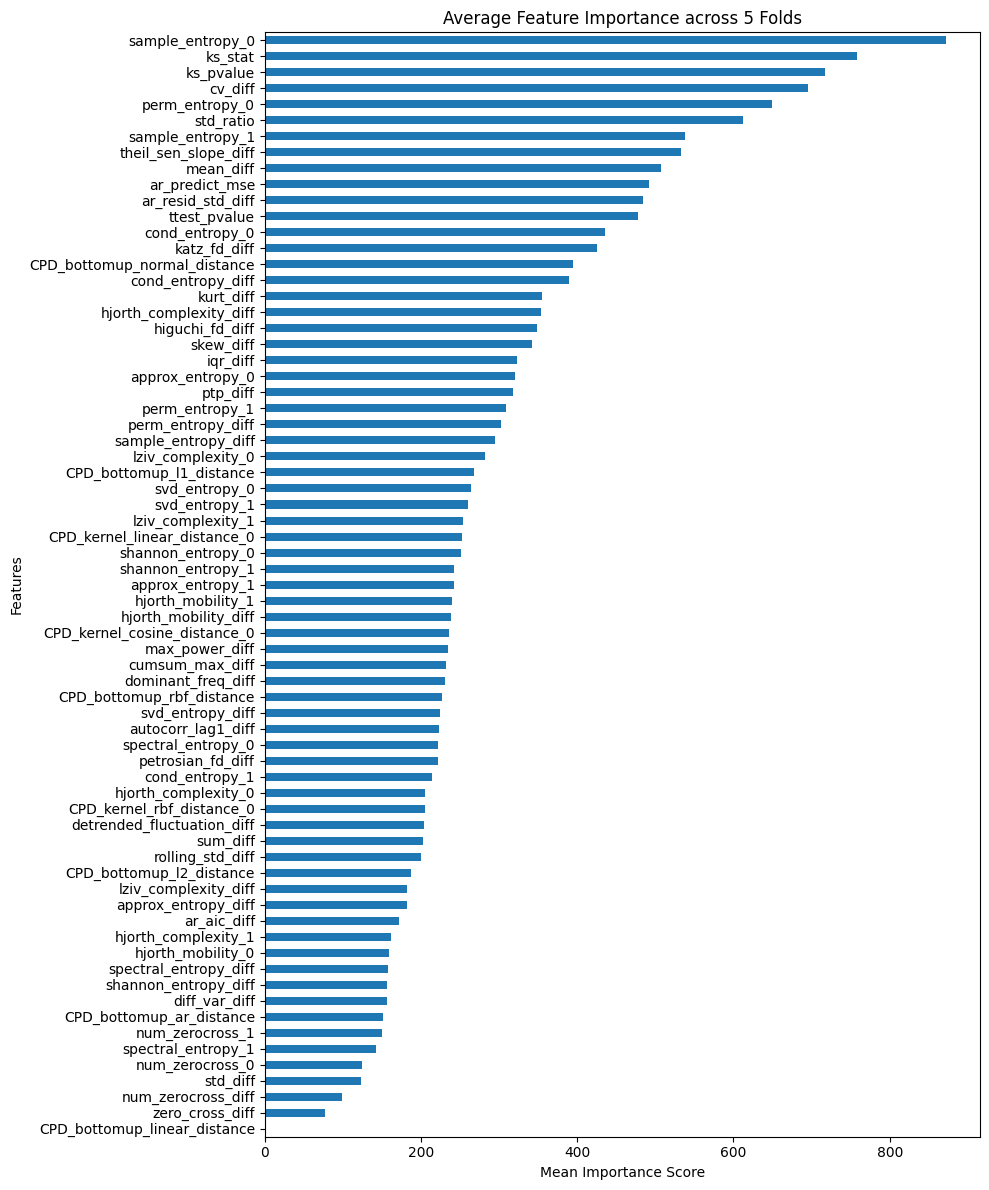

In [11]:
# 计算平均特征重要性
mean_feature_importance = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)
# 绘制特征重要性图表
plt.figure(figsize=(10, 12))
mean_feature_importance.sort_values().plot(kind='barh')
plt.title('Average Feature Importance across 5 Folds')
plt.xlabel('Mean Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()